In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import network.builders as bldrs
from sklearn.metrics import accuracy_score, f1_score

### Data Preprocessing

First, get all of the data, and combine the 25 headlines into one string for each row, stripping the junk characters off of the beginnings and ends of the strings, and adding the delimiter token.  Save this to a new file as a checkpoint.

In [2]:
data = pd.read_csv('../data/Combined_News_DJIA.csv', header=0, na_values=[])
data.fillna('', inplace=True)
data['Combined'] = ''
for i in range(1, 26):
    data['Combined'] += ' ||new_headline|| ' + \
                        data['Top'+str(i)].str.strip('b\\\'" ')
    data = data.drop('Top'+str(i), axis=1)

data.to_csv('../data/headlines_combined.csv')

Now, split the combined strings into lists of words, remove stop words, and tokenize these lists.

In [3]:
from nltk import word_tokenize
from nltk.corpus import stopwords

#make sure to run
#nltk.download()
punc_tokens = {'.': '||period||',
               ',': '||comma||',
               '"': '||quotation||',
               ';': '||semicolon||',
               '!': '||exclamation||',
               '?': '||question||',
               '(': '||left_paren||',
               ')': '||right_paren||',
               '--': '||hyphen||',
               '-': '||hyphen||',
               ':': '||colon||',
               '[': '||left_brack||',
               ']': '||right_brack||',
               '{': '||left_curly||',
               '}': '||right_curly||',
               '\n': '||newline||'}


def _split_remove_stopwords_tokenize_punc(combined_string):
    words = word_tokenize(combined_string)
    words = [word for word in words if word not in stopwords.words('english')]
    return [word.lower() if word not in punc_tokens.keys() else punc_tokens[word] for word in words]


def _tokenize_word_lists(row_list, words_to_int):
    return ' '.join([str(words_to_int[word]) for word in row_list])


def do_split():
    data = pd.read_csv('../data/headlines_combined.csv', header=0)
    data['Combined'] = data.apply(lambda row: _split_remove_stopwords_tokenize_punc(row['Combined']), axis=1)

    words = set()
    for index, row in data.iterrows():
        words.update(row[3])

    words_to_int = {word: index for index, word in enumerate(words)}

    data['Combined'] = data.apply(lambda row: _tokenize_word_lists(row['Combined'], words_to_int), axis=1)

    data.to_csv('../data/tokenized_headlines.csv')

In [4]:
do_split()

### Network Parameters

In [21]:
file_path = '../data/tokenized_headlines.csv'
#string creation and batch hyperparameters
split_frac = 0.8
batch_size = 198
length = 420
subsample_thresh = 10**-1
#network hyperparameters
num_epochs = 100
rnn_size = 16
embed_dim = 150
learning_rate = 0.001
dropout_keep_rate = 0.3

### Get Data and Create Batches

In [22]:
data, vocab = bldrs.get_data_and_vocab(file_path)
train_x, val_x, test_x, train_y, val_y, test_y = bldrs.get_data_splits(split_frac, data)
train_x, val_x, test_x = bldrs.create_lists_and_filter(train_x, val_x, test_x, subsample_thresh)
train_batches = bldrs.get_batches_and_pad(train_x, train_y, batch_size, length)
val_batches = bldrs.get_batches_and_pad(val_x, val_y, batch_size, length)
test_batches = bldrs.get_batches_and_pad(test_x, test_y, batch_size, length)
vocab_size = len(vocab)

### Build Network

In [23]:
train_graph = tf.Graph()
logs_path = 'logs/'
with train_graph.as_default():
    inputs, targets = bldrs.build_inputs_and_targets()
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    input_shape = tf.shape(inputs)
    embedding_layer = bldrs.build_embedding_layer(inputs, vocab_size, embed_dim)
    cell, initial_state = bldrs.build_lstm_cell(rnn_size, batch_size, keep_prob)
    rnn, final_state = bldrs.build_rnn(cell, embedding_layer)
    predictions = tf.contrib.layers.fully_connected(inputs=rnn[:,-1],
                                               num_outputs=1,
                                               activation_fn=tf.sigmoid,
                                               weights_initializer=tf.truncated_normal_initializer(),
                                               biases_initializer=tf.zeros_initializer(),
                                               trainable=True)
    cost = tf.losses.mean_squared_error(targets, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    saver = tf.train.Saver()
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), targets)
    return_predictions = tf.cast(tf.round(predictions), tf.int32)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


### Train Network

In [ ]:
training_losses = []
val_losses = [] 
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/1', sess.graph)
    iteration = 1
    for e in range(num_epochs):
        state = sess.run(initial_state)

        for index, batch in enumerate(train_batches):
            feed = {inputs: batch['headlines'],
                    targets: batch['labels'][:, None],
                    keep_prob: dropout_keep_rate,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            training_losses.append(loss)
            
            if iteration%5==0:
                print('Epoch: {}/{}'.format(e, num_epochs),
                      'Iteration: {}'.format(iteration),
                      'Train Loss: {:.3f}'.format(loss))

                # VALIDATE
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for val_index, val_batch in enumerate(val_batches):
                    feed = {inputs: val_batch['headlines'],
                            targets: val_batch['labels'][:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_cost, batch_acc, val_state = sess.run([cost, accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                    val_losses.append([batch_cost]*5)
                if iteration%25==0:
                    print("Validation Accuracy: {:.3f}".format(np.mean(val_acc)))
            iteration += 1
        saver.save(sess,"checkpoints/sentiment.ckpt")

Epoch: 0/100 Iteration: 5 Train Loss: 0.314
Epoch: 1/100 Iteration: 10 Train Loss: 0.287
Epoch: 1/100 Iteration: 15 Train Loss: 0.290
Epoch: 2/100 Iteration: 20 Train Loss: 0.257
Epoch: 3/100 Iteration: 25 Train Loss: 0.283
Validation Accuracy: 0.520
Epoch: 3/100 Iteration: 30 Train Loss: 0.287
Epoch: 4/100 Iteration: 35 Train Loss: 0.237
Epoch: 4/100 Iteration: 40 Train Loss: 0.249
Epoch: 5/100 Iteration: 45 Train Loss: 0.245
Epoch: 6/100 Iteration: 50 Train Loss: 0.235
Validation Accuracy: 0.520
Epoch: 6/100 Iteration: 55 Train Loss: 0.239
Epoch: 7/100 Iteration: 60 Train Loss: 0.233


### Plot Learning Curves

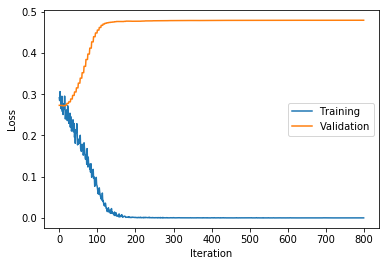

In [20]:
val_losses_flat = [value for sublist in val_losses for value in sublist]
plt.plot(training_losses, label='Training')
plt.plot(val_losses_flat, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.legend()

### Test Network

In [10]:
test_acc = []
test_pred = []
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for test_index, test_batch in enumerate(test_batches):
        feed = {inputs: test_batch['headlines'],
                targets: test_batch['labels'][:, None],
                keep_prob: 1.0,
                initial_state: test_state}
        test_batch_acc, test_state, test_batch_pred = sess.run([accuracy, final_state, return_predictions], feed_dict=feed)
        test_batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(test_batch_acc)
        test_pred.append(test_batch_pred)
    print("Test Accuracy: {:.3f}".format(np.mean(test_acc)))
    print("Test F score: {:.3f}".format(f1_score([value[0] for sublist in test_pred for value in sublist], test_y[:batch_size],
                                                labels=[0,1],average='macro')))
    

INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Test Accuracy: 0.535
Test F score: 0.349


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Benchmark

In [11]:
test_points = len(test_batches)*batch_size
bench_candidate_1 = [0]*test_points
bench_candidate_2 = [1]*test_points
cand_accs = [accuracy_score(bench_candidate_1, test_y[:test_points]),accuracy_score(bench_candidate_2, test_y[:test_points])]
print(cand_accs)

[0.46464646464646464, 0.53535353535353536]


We see that the benchmark candidate containing all 1's has the better accuracy score, which is .5377.

In [12]:
bench_f_score = f1_score(bench_candidate_2, test_y[:test_points], labels=[0,1],average='macro')
print(bench_f_score)

0.348684210526


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The f-score for the benchmark is 0.3497.  The warning that is printed is expected.  We are taking the mean of the f-scores for both classes.  Because there are no true positives for class 0, the f-score for that class will have 0 in the denominator, and is thus undefined.  Therefore, it is set to 0.